# sequence prediction sandbox
Incorporate all new code pieces from:
* Using GPU
* Using Optuna on Linear and CNN
* now add k-mer

But to add kmer, I need to re-org data loaders
  * Goal: make OHE happen in model, not data loader

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# create all possible n-mers for 8
def kmers(k):
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

def count_kmers_in_seq(seq, mers):
    '''
    For a given sequence and kmer set, return the count
    '''
    return [seq.count(mer) for mer in mers]

seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [4]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [5]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

seq   score
0  AAAAAAAA  20.000
1  AAAAAAAC  19.625
2  AAAAAAAG  19.250
3  AAAAAAAT  18.875
4  AAAAAACA  19.625

In [40]:
mer8_motif = score_seqs_motif(seqs8)
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)


In [8]:
mer8_motif[mer8['seq']=='TGCGTTTT']

seq  score
59135  TGCGTTTT    2.5

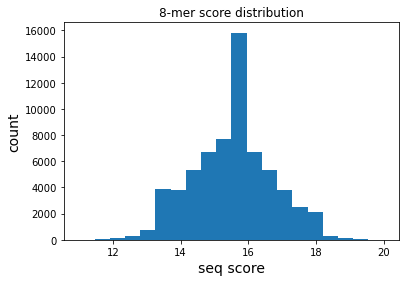

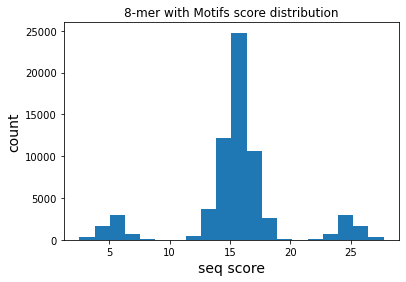

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define basic model arch for linear and CNN

In [10]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        
        #print("og shape?",xb.shape)
        #xb = xb.flatten()
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        #print("flattened shape?",xb.shape)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out



In [11]:
class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [12]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()


def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        #u.quick_seq_pred(model, seqs, oracle)
        quick_seq_pred(model, seqs, oracle)
        print()

## try defining flexible model class with Optuna

In [42]:
# defining a deep linear model with Optuna
class DNA_Linear_Opt(nn.ModuleList):
    def __init__(self, trial, seq_len):
        super().__init__()
        
        self.seq_len = seq_len
        # Where the layers and dropouts will be stacked
        layers = []
        
        # Given a trial, takes the suggested number of 
        # layers as well as the dropout value  
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        #dropout = trial.suggest_categorical('dropout',[0,0.1,0.2,0.3])
        print("linear layer num:", n_hidden_fc)
        
        # input sequence size
        input_dim = 4*seq_len
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        prev_linear_node_num = input_dim
        for i in range(1,n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            #output_dim = trial.suggest_int(f"output_dim_{layer}", 1, 100)#, log=True)
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
        
        # concat all the layers together
        self.lin = nn.Sequential(*layers)
        
#         # The last layer is added to the stack.
#         self.layers.append(nn.Linear(input_dim, 1))
#         self.dropouts.append(nn.Dropout(0)) # IDENTITY - use for balanced for loop in forward()
        
        
#         # PyTorch needs each layer, dropout, etc to be defined as an instance 
#         # variable of the class. E.g. self.layer_1 = nn.Linear(in, out)
#         # Thus we need to create such instance variable from the list of stacked 
#         # layers and dropouts with the "setattr" method.
#         for idx, layer in enumerate(self.layers):
#             setattr(self, f"fc_{idx}", layer)

#         for idx, dropout in enumerate(self.dropouts):
#             setattr(self, f"dr_{idx}", dropout)
            
    def forward(self, xb):

        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        
#         x = xb #?
        
#         for layer, dropout in zip(self.layers, self.dropouts):
#             x = layer(x)
#             x = F.relu(x)
#             x = dropout(x)
        
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

# Try with 8 mers

In [14]:
from torch.utils.data import Dataset,DataLoader #, TensorDataset

In [19]:
class SeqDatasetOHE(Dataset):
    '''
    Multi-task for one-hot-encoded sequences
    '''
    def __init__(self,df,target_col='score'):
        self.seqs = list(df['seq'].values)
        self.seq_len = len(self.seqs[0])
        
        self.ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in self.seqs])
    
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        #seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        #seq = torch.tensor(self.ohe_seqs[idx])
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label
    
class SeqDatasetKmer(Dataset):
    '''
    Multi-task for k-mer vector sequences
    '''
    def __init__(self,df,k=3,target_col='score'):
        self.seqs = list(df['seq'].values)
        self.seq_len = len(self.seqs[0])
        self.kmers = kmers(k)
        
        self.kmer_vecs = torch.stack([torch.tensor(count_kmers_in_seq(x,self.kmers)) for x in self.seqs])
    
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        #kmer_vec = torch.tensor(self.kmer_vecs[idx])
        #label = torch.tensor(float(self.labels[idx])).unsqueeze(1)
        kmer_vec = self.kmer_vecs[idx]
        label = self.labels[idx]
        
        return kmer_vec, label
    
    


In [20]:
class DatasetSpec():
    '''
    Quick access class for speciying the type of dataset to build
    '''
    def __init__(self,ds_type,k=None):
        self.name = ds_type
        self.k = k
        
        self.id = self.name if not k else f"{self.name}_{k}"
        
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=1),
    DatasetSpec('kmer',k=3),
]


In [21]:
def build_dataloaders_single(df, 
                             ds_specs,
                             target_col="score",
                             batch_size=32
                            ):
    '''
    Given a df, split into train and test, and encode the sequence for modeling 
    based on the requested dataset types (eg OHE or Kmer counts). Load each 
    Dataset into a pytorch loaders. 
    '''
    
    # split
    train_df, test_df = u.quick_split(df)
    
    dls = {} # collect data loaders
    
    for ds in ds_specs:
        # Kmer data set
        if ds.name == 'kmer':
            if not ds.k:
                raise ValueError(f"To use SeqDatasetKmer, you must specify an integer value for k in DatasetSpec")
            assert(type(ds.k) == int)
            
            train_ds = SeqDatasetKmer(train_df, ds.k)
            test_ds = SeqDatasetKmer(test_df, ds.k)
            
        # One-hot encoding
        elif ds.name == 'ohe':
            train_ds = SeqDatasetOHE(train_df)
            test_ds = SeqDatasetOHE(test_df)
            
        # unknown datatype?
        else:
            raise ValueError(f"Unknown Dataset Type {ds.name}.")

        # Put DataSets into DataLoaders
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
        dls[ds.id] = (train_dl,test_dl)
    
    return train_df, test_df, dls

In [22]:
mer8motif_train_df, \
mer8motif_test_df, \
dls = build_dataloaders_single(mer8_motif, dataset_types, batch_size=13)

kmer1_train_dl,kmer1_test_dl = dls['kmer_1']
kmer3_train_dl,kmer3_test_dl = dls['kmer_3']
ohe_train_dl,ohe_test_dl = dls['ohe']

In [23]:
kmer1_train_dl

In [24]:
for x,y in kmer3_train_dl:
    print(x)
    print(y)
    break

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

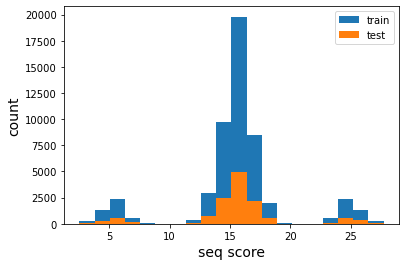

In [25]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

# TEMP FUNCS

In [26]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

0 12.75175495963654
1 12.76992316338068
2 12.730233165979167
3 12.744931960091344
4 12.776081419305754
5 12.748588507117969
6 12.70670446774419
7 12.803751064521858
8 12.846075680185317
9 12.779674113960866
10 12.750968698742989
11 12.755451388918557
12 12.757762689560625
13 12.795074200408285
14 12.77994690381211
15 12.8229529790337
16 12.754704698670155
17 12.839548424318282
18 12.77912898379417
19 12.740860330665624


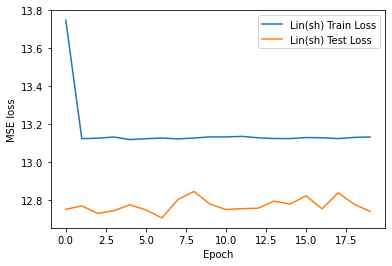

In [27]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_s = DNA_Linear_Shallow(seq_len)
mer8motif_model_lin_s.to(device)

mer8motif_train_losses_lin_s, mer8motif_test_losses_lin_s = run_model(
    ohe_train_dl, 
    ohe_test_dl, 
    mer8motif_model_lin_s
)

# to plot loss
mer8motif_lin_s_data_label = list(zip([mer8motif_train_losses_lin_s,
                                       mer8motif_test_losses_lin_s], 
                                      ['Lin(sh) Train Loss',
                                       'Lin(sh) Test Loss']))
u.quick_loss_plot(mer8motif_lin_s_data_label)

## Deep Linear

0 12.411293660353916
1 5.714418496587562
2 4.625513389429233
3 3.007851397487351
4 3.0181620279517447
5 2.7251055878670907
6 2.683391849099135
7 2.2439219989371364
8 1.738388152624235
9 1.5482029972173361
10 1.2446987544290715
11 1.3548423495242554
12 1.173614314964469
13 1.0706708660024693
14 2.4263634545422197
15 1.2459237416970281
16 1.0053132855613893
17 1.6704616851713605
18 2.1214243949237197
19 1.236687095742019


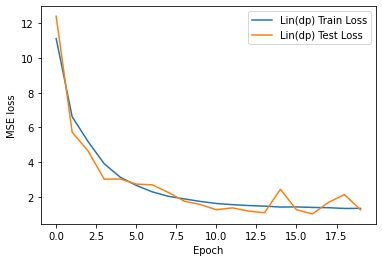

In [34]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)
mer8motif_model_lin_d.to(device)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

## Kmer linear

0 13.724460873783526
1 13.394266239246072
2 13.243971381439898
3 13.168507935881141
4 13.048077675493746
5 13.614567043979902
6 13.32464847548873
7 13.198870119026859
8 13.219962508041101
9 13.020713875360666
10 13.22177640318434
11 13.060193730239138
12 13.148268342736584
13 13.140994780518167
14 13.316226860572552
15 13.476663777613226
16 13.115265147166532
17 13.174148617828987
18 13.82865251302901
19 13.246401291960145


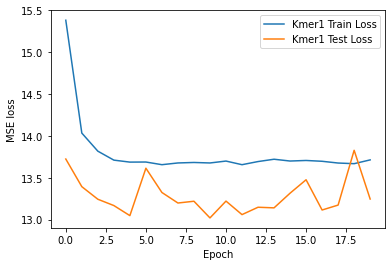

In [53]:
# K=1
h1 = 10
h2 = 10
num_kmers = len(kmer1_train_dl.dataset.kmers)

mer8motif_model_kmer1 = Kmer_Linear(num_kmers, h1,h2)
mer8motif_model_kmer1.to(device)

mer8motif_train_losses_kmer1, mer8motif_test_losses_kmer1 = run_model(
    kmer1_train_dl, 
    kmer1_test_dl, 
    mer8motif_model_kmer1
)

# to plot loss
mer8motif_kmer1_data_label = list(zip([mer8motif_train_losses_kmer1,
                                       mer8motif_test_losses_kmer1], 
                                      ['Kmer1 Train Loss',
                                       'Kmer1 Test Loss']))
u.quick_loss_plot(mer8motif_kmer1_data_label)


0 0.36057999075882347
1 0.2810407267251928
2 0.11976008116488444
3 0.15875757951857816
4 0.1108139800663775
5 0.10273633535148796
6 0.1195822274282536
7 0.09532625079316961
8 0.08008157509257735
9 0.0821783382818657
10 0.07495703802025983
11 0.09222469397131064
12 0.08715588929029884
13 0.07223005428953454
14 0.07077520950360586
15 0.06792822206368158
16 0.06513164093152944
17 0.06404078343137416
18 0.06716879921717195
19 0.09563462295406633


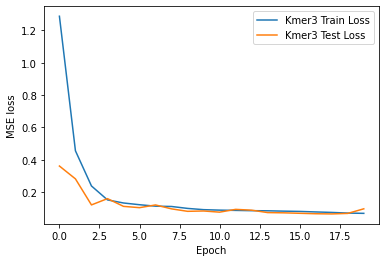

In [54]:
# K=3
h1 = 10
h2 = 10
num_kmers = len(kmer3_train_dl.dataset.kmers)

mer8motif_model_kmer3 = Kmer_Linear(num_kmers, h1,h2)
mer8motif_model_kmer3.to(device)

mer8motif_train_losses_kmer3, mer8motif_test_losses_kmer3 = run_model(
    kmer3_train_dl, 
    kmer3_test_dl, 
    mer8motif_model_kmer3
)

# to plot loss
mer8motif_kmer3_data_label = list(zip([mer8motif_train_losses_kmer3,
                                       mer8motif_test_losses_kmer3], 
                                      ['Kmer3 Train Loss',
                                       'Kmer3 Test Loss']))
u.quick_loss_plot(mer8motif_kmer3_data_label)


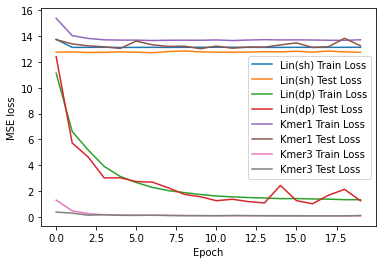

In [56]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_kmer1_data_label + \
    mer8motif_kmer3_data_label + \
)


## Optuna objective functions
study.optimize seems to only take trial as an input and automatically. In order to pass epochs and train/test data loaders, I think I have to wrap it in an extra Model class? Then calls the Model's self.objective?

In [28]:
class OptWrap:
    '''
    Adapted from: 
    https://github.com/FernandoLpz/Optuna-Sklearn-PyTorch/blob/master/optuna_pytorch.py
    
    Optuna needs to call "study.optimize" on a function with no inputs other 
    than trial... trying to make that happen here...
    '''
    
    def __init__(self, 
                 name, 
                 model_class, 
                 seq_len, 
                 epochs, 
                 loss_func, 
                 train_loader, 
                 test_loader
                ):
        self.name = name
        self.model_class = model_class
        self.seq_len = seq_len
        self.epochs = epochs
        self.loss_func = loss_func
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_loss_list = []
        self.test_loss_list = []
        self.trial_count = 0
        self.best_train_loss = None
        self.best_test_loss = None
        self.best_model = None
        
    def optimize(self, trial):
        self.trial_count += 1 # increments with trials run for this model
        # Initialize model with the current trial
        model = self.model_class(trial, self.seq_len).to(device)
        train_losses = []
        test_losses = []
        # ^^ collect per trial
        
        # Define space search for training settings
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = train_step(model, self.train_loader, loss_func, opt)
            
            test_loss = val_step(model, self.test_loader, loss_func)
            print(epoch, test_loss)
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            # decide if trial should be pruned
            trial.report(test_loss, epoch)
            if trial.should_prune():
                # add partial trials to the train history
                self.train_loss_list.append(train_losses)
                self.test_loss_list.append(test_losses)
                
                raise optuna.exceptions.TrialPruned()
                
        
        # return history of this trials training/test loss?
        self.train_loss_list.append(train_losses)
        self.test_loss_list.append(test_losses)
        
        # return final test loss?? or best test loss?? 
        # TODO/QUESTION: try best test loss instead of final
        # CALLBACKS?
        
        print("Model Arch:",model)
        return test_loss
    
    def retrain_best(self, trial):
        '''
        Use a Frozen trial to retrain/return a model with the 
        best hyperparameters
        '''
        assert(type(trial) == optuna.trial.FrozenTrial)
        
        model = self.model_class(trial, self.seq_len).to(device)
        train_losses = []
        test_losses = []
        
        # Define space search for training settings
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = train_step(model, self.train_loader, loss_func, opt)
            
            test_loss = val_step(model, self.test_loader, loss_func)
            print(epoch, test_loss)
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        # Update history for current best
        if self.best_model is not None:
            print("Warning: overwriting best model with new best model")
        self.best_train_loss = train_losses
        self.best_test_loss = test_losses
        self.best_model = model
        
        return model
            
        
        



In [35]:
def print_study(study):
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

## Optuna model

In [43]:
seq_len = len(mer8motif_train_df['seq'].values[0])
eps=20
loss_func = torch.nn.MSELoss()

ow = OptWrap(
    "DNA_Linear_Opt",
    DNA_Linear_Opt,
    seq_len,
    eps,
    loss_func,
    ohe_train_dl, 
    ohe_test_dl
)

In [44]:
ow.trial_count

0

In [45]:
study = optuna.create_study(direction="minimize")

[I 2021-09-24 19:02:16,754] A new study created in memory with name: no-name-cd340767-5830-498c-b0f8-aafc963f4e41


In [46]:
study.optimize(ow.optimize, n_trials=3)

linear layer num: 2
lin1_fc_nodes 32
lin1_dropout 0.3
lin2_fc_nodes 32
lin2_dropout 0.2
0 15.671479069912873
1 17.821572458149276
2 17.65966628361374
3 17.57060982317851
4 17.533837455472895
5 17.593146559497843
6 17.739707565640472
7 17.52687575303639
8 17.6021830150184
9 17.61364957995356
10 17.7095998168892
11 17.52686105006473
12 17.54752390666873
13 17.86092846020988
14 17.566128168381276
15 17.61600241785756
16 17.557772527903836
17 17.55076651949507
18 17.552801182621458


[I 2021-09-24 19:03:49,407] Trial 0 finished with value: 17.78945028925582 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.3, 'lin2_fc_nodes': 32, 'lin2_dropout': 0.2, 'optimizer': 'SGD', 'lr': 0.047634180595076896}. Best is trial 0 with value: 17.78945028925582.


19 17.78945028925582
Model Arch: DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
linear layer num: 2
lin1_fc_nodes 8
lin1_dropout 0.2
lin2_fc_nodes 8
lin2_dropout 0.2
0 40.17810970579374
1 21.031847701549786
2 16.933477209750784
3 15.395973299593324
4 15.095595253775278
5 14.451066091970441
6 14.258610725830268
7 14.276504199980307
8 13.773277574153727
9 14.056948494085423
10 13.6390015315111
11 13.72953678056857
12 13.672426863954604
13 13.590629218271822
14 13.528510308644012
15 13.530139427078472
16 13.608629510138579
17 13.58499247646019
18 13.482293439722659


[I 2021-09-24 19:05:21,554] Trial 1 finished with value: 13.437807233087312 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 8, 'lin1_dropout': 0.2, 'lin2_fc_nodes': 8, 'lin2_dropout': 0.2, 'optimizer': 'SGD', 'lr': 1.4857138229675805e-05}. Best is trial 1 with value: 13.437807233087312.


19 13.437807233087312
Model Arch: DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
linear layer num: 0
0 12.945027834327984
1 12.776062230393403
2 12.769575198430784
3 12.96613111660944
4 13.408276696047988
5 13.077927905137415
6 13.050039033755901
7 12.856965450531904
8 13.228428696236453
9 12.80258006688695
10 12.898674862174534
11 12.954695813605651
12 12.944209726911003
13 12.88970334159917
14 12.893995605265909
15 12.898059412095835
16 12.887266445039867
17 13.063489099755897
18 12.851097553813824


[I 2021-09-24 19:06:28,020] Trial 2 finished with value: 12.905245486177392 and parameters: {'n_hidden_fc': 0, 'optimizer': 'Adam', 'lr': 0.03359614785530847}. Best is trial 2 with value: 12.905245486177392.


19 12.905245486177392
Model Arch: DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [47]:
print_study(study)

Study statistics: 
  Number of finished trials:  3
  Number of pruned trials:  0
  Number of complete trials:  3
Best trial:
  Value:  12.905245486177392
  Params: 
    n_hidden_fc: 0
    optimizer: Adam
    lr: 0.03359614785530847


In [48]:
study.best_trial.number

2

In [49]:
best_lin = ow.retrain_best(study.best_trial)

linear layer num: 0
0 12.822235734116424
1 12.944735972227248
2 12.892144302369474
3 12.849904523759417
4 12.816109606340815
5 12.922630358695402
6 12.977588248827635
7 13.125211522387847
8 13.00901038653246
9 12.976295166838485
10 12.921412326938901
11 12.901167631822277
12 13.588178188490875
13 12.891153523934335
14 13.002844491327249
15 13.06597204245843
16 12.8622996259616
17 12.865291320189929
18 12.895599460743679
19 13.163189503435031


In [51]:
quick_test8(best_lin, oracle_8mer_motif)

AAAAAAAA: pred:23.031 actual:20.000 (-3.031)
CCCCCCCC: pred:13.194 actual:17.000 (3.806)
GGGGGGGG: pred:6.451 actual:14.000 (7.549)
TTTTTTTT: pred:17.411 actual:11.000 (-6.411)

AACCAACA: pred:18.488 actual:18.875 (0.387)
CCGGCGCG: pred:8.957 actual:5.500 (-3.457)
GGGTAAGG: pred:14.003 actual:15.125 (1.122)
TTTCGTTT: pred:14.296 actual:12.125 (-2.171)
TGTAATAC: pred:19.370 actual:15.500 (-3.870)

TATAAAAA: pred:21.870 actual:27.750 (5.880)
CCTATCCC: pred:16.487 actual:25.875 (9.388)
GTATGGGG: pred:11.849 actual:24.000 (12.151)
TTTATTTT: pred:18.114 actual:22.125 (4.011)

AAGCGAAA: pred:15.596 actual:8.125 (-7.471)
CGCGCCCC: pred:12.238 actual:6.250 (-5.988)
GGGCGGGG: pred:7.365 actual:4.375 (-2.990)
TTGCGTTT: pred:12.040 actual:2.500 (-9.540)

ATATGCGA: pred:14.834 actual:15.875 (1.041)
TGCGTATT: pred:15.236 actual:13.625 (-1.611)



### CNN Optuna Trial

In [126]:
class DNA_CNN_Opt(nn.Module):
    def __init__(self,
                 trial,
                 seq_len,
                ):
        super().__init__()
        self.seq_len = seq_len
        layers = []
        
        # +---------------------+
        # | First Conv Layer (0)|
        # +---------------------+
        conv0_filt_num = trial.suggest_categorical('conv0_filt_num', [16,32,64])
        conv0_kernel_size = trial.suggest_int('conv0_kernel_size',1,1)
        conv0_pool_size = trial.suggest_int('conv0_pool_size',1,2)
        conv0_dropout = trial.suggest_categorical('conv0_dropout',[0,0.1,0.2,0.3])
        
        print("conv0_filt_num", conv0_filt_num)
        print("conv0_kernel_size", conv0_kernel_size)
        print("conv0_pool_size", conv0_pool_size)
        
        linear_node_num = int(np.floor((seq_len - conv0_kernel_size + 1)/conv0_pool_size))
        print("current linear_node_num:",linear_node_num )
        
        layers.append(nn.Conv2d(1, conv0_filt_num, kernel_size=(4,conv0_kernel_size)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d((1,conv0_pool_size))) # def stride = kernel_size
        layers.append(nn.Dropout(conv0_dropout))

        
        # +-----------------------+
        # | Hidden Conv Layers (N)|
        # +-----------------------+
        n_hidden_conv = trial.suggest_int('n_hidden_conv',0,1)
        print("hidden conv layers:", n_hidden_conv)
        prev_conv_filt_num = conv0_filt_num
        
        # for each hidden convolutional layer
        for i in range(1,n_hidden_conv+1):
            # Trial Suggestions
            convi_filt_num = trial.suggest_categorical(f'conv{i}_filt_num', [16,32,64])
            convi_kernel_size = trial.suggest_int(f'conv{i}_kernel_size',2,3)
            convi_pool_size = trial.suggest_int(f'conv{i}_pool_size',1,2)
            convi_dropout = trial.suggest_categorical(f'conv{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"conv{i}_filt_num", convi_filt_num)
            print(f"conv{i}_kernel_size", convi_kernel_size)
            print(f"conv{i}_pool_size", convi_pool_size)
            print(f"conv{i}_dropout", convi_dropout)
            
            # Layer additions
            layers.append(nn.Conv2d(prev_conv_filt_num, convi_filt_num, kernel_size=(1,convi_kernel_size)))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d((1,convi_pool_size)))
            layers.append(nn.Dropout(convi_dropout))
            
            # value updates
            linear_node_num = int(np.floor((linear_node_num - convi_kernel_size + 1)/convi_pool_size))
            print("current linear_node_num:",linear_node_num )
            prev_conv_filt_num = convi_filt_num
        
        # flatten the conv layers pre FC layer
        layers.append(nn.Flatten())
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        print("n fc layers:", n_hidden_fc)
        
        prev_linear_node_num = linear_node_num*prev_conv_filt_num
        print("From Conv-to-FC node num:",prev_linear_node_num)
        
        for i in range(1, n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
            print("current linear_node_num:",prev_linear_node_num )
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
            
        # concat all the layers together
        self.conv_net = nn.Sequential(*layers)
            


    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [127]:
for i in range(1,10+1):
    print(f"hi {i}")

hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10


In [128]:
seq_len = len(mer8motif_train_df['seq'].values[0])
eps=20
loss_func = torch.nn.MSELoss()

owcnn = OptWrap(
    "DNA_CNN_Opt",
    DNA_CNN_Opt,
    seq_len,
    eps,
    loss_func,
    mer8motif_train_dl, 
    mer8motif_test_dl
)

In [129]:
owcnn.trial_count

0

In [130]:
studycnn = optuna.create_study(direction="minimize")

[I 2021-09-22 21:43:37,864] A new study created in memory with name: no-name-d18f4480-0c99-4aff-9714-216256d3351c


In [131]:
studycnn.optimize(owcnn.optimize, n_trials=10)

conv0_filt_num 16
conv0_kernel_size 1
conv0_pool_size 2
current linear_node_num: 4
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 2
conv1_pool_size 2
conv1_dropout 0.2
current linear_node_num: 1
n fc layers: 1
From Conv-to-FC node num: 16
lin1_fc_nodes 16
lin1_dropout 0.2
current linear_node_num: 16
0 15.140838154967616
1 14.186875262491798
2 13.44210945825079
3 13.424880867665374
4 13.003520050307472
5 13.258664695462477
6 13.342900103454296
7 12.923201674908663
8 12.8203805687226
9 12.6753252650093
10 12.523784824195417
11 12.619200946519314
12 12.338290720323181
13 12.340517896584778
14 12.304108751449492
15 12.470432104408141
16 12.060551164824679
17 12.045486043830598
18 12.251360428389667


[I 2021-09-22 21:46:14,124] Trial 0 finished with value: 11.92259472038348 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 1, 'conv0_pool_size': 2, 'conv0_dropout': 0.1, 'n_hidden_conv': 1, 'conv1_filt_num': 16, 'conv1_kernel_size': 2, 'conv1_pool_size': 2, 'conv1_dropout': 0.2, 'n_hidden_fc': 1, 'lin1_fc_nodes': 16, 'lin1_dropout': 0.2, 'optimizer': 'SGD', 'lr': 0.0001177037250411793}. Best is trial 0 with value: 11.92259472038348.


19 11.92259472038348
Model Arch: DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(1, 2), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16, out_features=16, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)
conv0_filt_num 16
conv0_kernel_size 1
conv0_pool_size 2
current linear_node_num: 4
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 64
lin1_fc_nodes 32
lin1_dropout 0.3
current linear_node_num: 32
lin2_fc_nodes 16
lin2_dropout 0.1
current

[I 2021-09-22 21:48:31,490] Trial 1 finished with value: 16.188451982238853 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 1, 'conv0_pool_size': 2, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 2, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.3, 'lin2_fc_nodes': 16, 'lin2_dropout': 0.1, 'optimizer': 'SGD', 'lr': 0.008090862087045013}. Best is trial 0 with value: 11.92259472038348.


19 16.188451982238853
Model Arch: DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=16, out_features=1, bias=True)
  )
)
conv0_filt_num 64
conv0_kernel_size 1
conv0_pool_size 2
current linear_node_num: 4
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 2
n fc layers: 2
From Conv-to-FC node num: 128
lin1_fc_nodes 16
lin1_dropout 0.3
current linear_node_num: 16
lin2_fc_nodes 64
lin2_dropout 0.3


[I 2021-09-22 21:51:22,721] Trial 2 finished with value: 9.872994121319826 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 1, 'conv0_pool_size': 2, 'conv0_dropout': 0, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 3, 'conv1_pool_size': 1, 'conv1_dropout': 0, 'n_hidden_fc': 2, 'lin1_fc_nodes': 16, 'lin1_dropout': 0.3, 'lin2_fc_nodes': 64, 'lin2_dropout': 0.3, 'optimizer': 'SGD', 'lr': 0.0010945310213307665}. Best is trial 2 with value: 9.872994121319826.


19 9.872994121319826
Model Arch: DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=128, out_features=16, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=64, bias=True)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=1, bias=True)
  )
)
conv0_filt_num 16
conv0_kernel_size 1
conv0_pool_size 1
current linear_node_num: 8
hidden conv layers: 0
n fc layers: 2
From 

[I 2021-09-22 21:53:36,273] Trial 3 finished with value: 12.504377544290016 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 1, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 2, 'lin1_fc_nodes': 8, 'lin1_dropout': 0, 'lin2_fc_nodes': 8, 'lin2_dropout': 0.1, 'optimizer': 'SGD', 'lr': 9.028003222206659e-05}. Best is trial 2 with value: 9.872994121319826.


19 12.504377544290016
Model Arch: DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=128, out_features=8, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=8, out_features=8, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=8, out_features=1, bias=True)
  )
)
conv0_filt_num 64
conv0_kernel_size 1
conv0_pool_size 2
current linear_node_num: 4
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 256
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
0 12.207600174133539
1 12.044250853602975
2 11.407269754431981
3 11.643672512304795
4 11.309414900946187
5 12.127443832688336
6 11.327646475

[I 2021-09-22 21:55:52,877] Trial 4 finished with value: 12.059643526479425 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 1, 'conv0_pool_size': 2, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0, 'optimizer': 'RMSprop', 'lr': 0.030554018010315234}. Best is trial 2 with value: 9.872994121319826.


19 12.059643526479425
Model Arch: DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=256, out_features=64, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
conv0_filt_num 16
conv0_kernel_size 1
conv0_pool_size 2
current linear_node_num: 4
hidden conv layers: 1
conv1_filt_num 16
conv1_kernel_size 3
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 2
n fc layers: 2
From Conv-to-FC node num: 32
lin1_fc_nodes 32
lin1_dropout 0.3
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0
current linear_node_num: 8
0 13.49726707436233


[I 2021-09-22 21:56:15,222] Trial 5 pruned. 


1 13.147054481449963
conv0_filt_num 32
conv0_kernel_size 1
conv0_pool_size 1
current linear_node_num: 8
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 256
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
lin2_fc_nodes 16
lin2_dropout 0.3
current linear_node_num: 16


[I 2021-09-22 21:56:23,205] Trial 6 pruned. 


0 18.7267858654779
conv0_filt_num 16
conv0_kernel_size 1
conv0_pool_size 1
current linear_node_num: 8
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 7
n fc layers: 2
From Conv-to-FC node num: 448
lin1_fc_nodes 16
lin1_dropout 0.2
current linear_node_num: 16
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32
0 2.6883027552057777
1 1.6454021139414274
2 1.7626684423869143
3 2.588111435799545
4 1.3184686297454737
5 1.0006488423327284
6 1.5323130077738423
7 1.850428056526619
8 1.4211729865897473
9 1.3896888296540768
10 1.608896963443831
11 1.3899350779930792
12 1.7356984389193872
13 1.3223056158526645
14 1.2306861976195134
15 1.244398062005139
16 1.255361737892018
17 3.674303732193986
18 1.6328987487247069


[I 2021-09-22 21:59:45,546] Trial 7 finished with value: 1.4880000908208542 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 1, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 2, 'conv1_pool_size': 1, 'conv1_dropout': 0.3, 'n_hidden_fc': 2, 'lin1_fc_nodes': 16, 'lin1_dropout': 0.2, 'lin2_fc_nodes': 32, 'lin2_dropout': 0.2, 'optimizer': 'RMSprop', 'lr': 0.009138235920092679}. Best is trial 7 with value: 1.4880000908208542.


19 1.4880000908208542
Model Arch: DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(16, 64, kernel_size=(1, 2), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=448, out_features=16, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=16, out_features=32, bias=True)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=32, out_features=1, bias=True)
  )
)
conv0_filt_num 32
conv0_kernel_size 1
conv0_pool_size 1
current linear_node_num: 8
hidden conv layers: 0
n fc layers: 1
Fr

[I 2021-09-22 21:59:57,410] Trial 8 pruned. 


1 12.701489655017344
conv0_filt_num 64
conv0_kernel_size 1
conv0_pool_size 2
current linear_node_num: 4
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 256
0 12.367114442530514
1 12.296957616994103
2 12.0505014094031
3 12.024591463775144
4 12.05001398575426
5 12.063007687991226
6 12.062287052375426
7 12.096765782171392
8 12.053166664297857


[I 2021-09-22 22:00:54,246] Trial 9 pruned. 


9 12.102072571958752


In [132]:
print_study(studycnn)

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  1.4880000908208542
  Params: 
    conv0_filt_num: 16
    conv0_kernel_size: 1
    conv0_pool_size: 1
    conv0_dropout: 0
    n_hidden_conv: 1
    conv1_filt_num: 64
    conv1_kernel_size: 2
    conv1_pool_size: 1
    conv1_dropout: 0.3
    n_hidden_fc: 2
    lin1_fc_nodes: 16
    lin1_dropout: 0.2
    lin2_fc_nodes: 32
    lin2_dropout: 0.2
    optimizer: RMSprop
    lr: 0.009138235920092679


In [133]:
studycnn.best_trial.number

7

In [134]:
owcnn.retrain_best(studycnn.best_trial)

conv0_filt_num 16
conv0_kernel_size 1
conv0_pool_size 1
current linear_node_num: 8
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 2
conv1_pool_size 1
conv1_dropout 0.3
current linear_node_num: 7
n fc layers: 2
From Conv-to-FC node num: 448
lin1_fc_nodes 16
lin1_dropout 0.2
current linear_node_num: 16
lin2_fc_nodes 32
lin2_dropout 0.2
current linear_node_num: 32
0 4.38294417921057
1 3.21612569131355
2 7.2958435430681705
3 1.811928774814781
4 2.677656941556934
5 1.9925235731661919
6 2.5558996436674675
7 2.515363867296009
8 3.115516612883163
9 4.085588293197245
10 3.5718985262634115
11 1.963851994447476
12 2.5837775297397005
13 6.366741296882705
14 2.139119431760695
15 2.585958231284846
16 2.533174589804925
17 4.975133496141393
18 1.8707418892251797
19 1.8624121320795133


DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(16, 64, kernel_size=(1, 2), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=448, out_features=16, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=16, out_features=32, bias=True)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [135]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(owcnn.best_model,oracle_8mer_motif)

AAAAAAAA: pred:18.372 actual:20.000 (1.628)
CCCCCCCC: pred:16.489 actual:17.000 (0.511)
GGGGGGGG: pred:13.560 actual:14.000 (0.440)
TTTTTTTT: pred:14.345 actual:11.000 (-3.345)

AACCAACA: pred:17.386 actual:18.875 (1.489)
CCGGCGCG: pred:5.793 actual:5.500 (-0.293)
GGGTAAGG: pred:15.434 actual:15.125 (-0.309)
TTTCGTTT: pred:14.345 actual:12.125 (-2.220)
TGTAATAC: pred:15.844 actual:15.500 (-0.344)

TATAAAAA: pred:25.069 actual:27.750 (2.681)
CCTATCCC: pred:21.952 actual:25.875 (3.923)
GTATGGGG: pred:22.105 actual:24.000 (1.895)
TTTATTTT: pred:21.219 actual:22.125 (0.906)

AAGCGAAA: pred:11.462 actual:8.125 (-3.337)
CGCGCCCC: pred:8.724 actual:6.250 (-2.474)
GGGCGGGG: pred:7.273 actual:4.375 (-2.898)
TTGCGTTT: pred:8.206 actual:2.500 (-5.706)

ATATGCGA: pred:15.915 actual:15.875 (-0.040)
TGCGTATT: pred:15.755 actual:13.625 (-2.130)



In [136]:
optuna.visualization.plot_optimization_history(studycnn)

In [137]:
optuna.visualization.plot_param_importances(studycnn)

ZeroDivisionError: Weights sum to zero, can't be normalized

In [139]:
optuna.visualization.plot_slice(studycnn)

In [140]:
optuna.visualization.plot_parallel_coordinate(studycnn)

### Why doesn't this plot show all trials in the study?

In [141]:
df = studycnn.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration'], axis=1)
df

number      value  params_conv0_dropout  params_conv0_filt_num  \
0       0  11.922595                   0.1                     16   
1       1  16.188452                   0.3                     16   
2       2   9.872994                   0.0                     64   
3       3  12.504378                   0.2                     16   
4       4  12.059644                   0.1                     64   
5       5  13.147054                   0.0                     16   
6       6  18.726786                   0.3                     32   
7       7   1.488000                   0.0                     16   
8       8  12.701490                   0.2                     32   
9       9  12.102073                   0.3                     64   

   params_conv0_kernel_size  params_conv0_pool_size  params_conv1_dropout  \
0                         1                       2                   0.2   
1                         1                       2                   NaN   
2                         1                       2                   0.0   
3                         1                       1                   NaN   
4                         1                       2                   NaN   
5                         1                       2                   0.2   
6                         1                       1                   NaN   
7                         1                       1                   0.3   
8                         1                       1                   NaN   
9                         1                       2                   NaN   

   params_conv1_filt_num  params_conv1_kernel_size  params_conv1_pool_size  \
0                   16.0                       2.0                     2.0   
1                    NaN                       NaN                     NaN   
2                   64.0                       3.0                     1.0   
3                    NaN                       NaN                     NaN   
4                    NaN                       NaN                     NaN   
5                   16.0                       3.0                     1.0   
6                    NaN                       NaN                     NaN   
7                   64.0                       2.0                     1.0   
8                    NaN                       NaN                     NaN   
9                    NaN                       NaN                     NaN   

   params_lin1_dropout  params_lin1_fc_nodes  params_lin2_dropout  \
0                  0.2                  16.0                  NaN   
1                  0.3                  32.0                  0.1   
2                  0.3                  16.0                  0.3   
3                  0.0                   8.0                  0.1   
4                  0.0                  64.0                  NaN   
5                  0.3                  32.0                  0.0   
6                  0.0                  64.0                  0.3   
7                  0.2                  16.0                  0.2   
8                  0.1                  64.0                  NaN   
9                  NaN                   NaN                  NaN   

   params_lin2_fc_nodes  params_lr  params_n_hidden_conv  params_n_hidden_fc  \
0                   NaN   0.000118                     1                   1   
1                  16.0   0.008091                     0                   2   
2                  64.0   0.001095                     1                   2   
3                   8.0   0.000090                     0                   2   
4                   NaN   0.030554                     0                   1   
5                   8.0   0.000290                     1                   2   
6                  16.0   0.000014                     0                   2   
7                  32.0   0.009138                     1                   2   
8                   NaN   0.000178                     0

# Next:
* how do you make a new model with the "best params"?
* Confirm that I believe the best params?
* Should I be returning the BEST test loss? or just the last one of the epoch?
    * seems like it's at risk to jumps at the end that ruin it?

In [36]:
len(ow.train_loss_list)

9

In [37]:
# for i in range(len(ow.train_loss_list)):
#     print("Epoch", i)
#     d = [(ow.train_loss_list[i],"Train Loss"), (ow.test_loss_list[i], "Test Loss")]
#     u.quick_loss_plot(d)
    

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


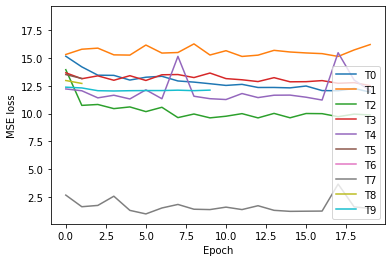

In [142]:
dd = []
for i in range(len(owcnn.test_loss_list)):
    print("Trial", i)
    dd += [(owcnn.test_loss_list[i], f"T{i}")]
u.quick_loss_plot(dd)

### Use best trial?

### CNN Model

0 0.45365984201033965
1 0.11009781747993319
2 0.08320063156174393
3 0.024859992419807186
4 0.020041678033238104
5 0.011208865270323559
6 0.04851500042757519
7 0.012669194277420272
8 0.008020521747595804
9 0.04132280512018738
10 0.008575784054937991
11 0.006425556217738641
12 0.007532110968067546
13 0.004595538359767201
14 0.018227173066915427
15 0.007744885511811404
16 0.0037388621335226768
17 0.0036954546821159114
18 0.0034930385912497557
19 0.007318497444983662


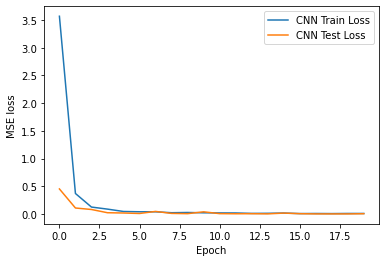

In [43]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len)
mer8motif_model_cnn.to(device)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn, 
    lr=0.01
)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [142]:
class DNA_CNN2(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters1=31,
                 num_filters2=17,
                 kernel_size1=3,
                 kernel_size2=1,
                 pool_size1=1,
                 pool_size2=1
                ):
        super().__init__()
        self.seq_len = seq_len

        #what number goes in linear layer??
        conv1_num = np.floor((seq_len - kernel_size1 + 1)/pool_size1)
        conv2_num = np.floor((conv1_num - kernel_size2 + 1)/pool_size2)
        lin_actual = int(conv2_num * num_filters2)
        
        print('conv1_num', conv1_num)
        print('conv2_num', conv2_num)
        print('lin_actual', lin_actual)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters1, kernel_size=(4,kernel_size1)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,pool_size1)), # stride = kernel_size
            nn.Dropout(0),
            
#             # next add another layer
            nn.Conv2d(num_filters1, num_filters2, kernel_size=(1,kernel_size2)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,pool_size2)),
            nn.Dropout(0),

            # next add another layer
            nn.Flatten(),
            nn.Linear(lin_actual, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
#         print(out)
#         print(out.shape)
        
        #print("CNN out shape:",out.shape)
        return out

conv1_num 6.0
conv2_num 6.0
lin_actual 102
0 0.33233780347505404
1 0.07737964348552642
2 0.08105740572550688
3 0.04663972825710433
4 0.024851204171068546
5 0.024170587051366814
6 0.023144352436662494
7 0.029230823256477526
8 0.038305606296357604
9 0.044950274262974606
10 0.014196363094886312
11 0.08097665662444425
12 0.0276745365046449
13 0.00505891256876316
14 0.07390327400550346
15 0.005533491120613448
16 0.023649183113515455
17 0.009681418260599156
18 0.012480697349531802
19 0.006325913667591175


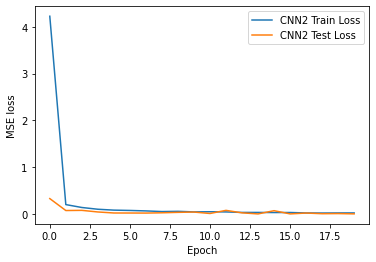

In [143]:
# attempt CNN with max pool n stuff

mer8motif_model_cnn2 = DNA_CNN2(seq_len)
mer8motif_model_cnn2.to(device)

mer8motif_train_losses_cnn2, \
mer8motif_test_losses_cnn2 = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn2, 
    lr=0.01
)

# to plot loss
mer8motif_cnn2_data_label = list(zip([mer8motif_train_losses_cnn2,mer8motif_test_losses_cnn2], ['CNN2 Train Loss','CNN2 Test Loss']))
u.quick_loss_plot(mer8motif_cnn2_data_label)

In [144]:
mer8motif_model_cnn2

DNA_CNN2(
  (conv_net): Sequential(
    (0): Conv2d(1, 31, kernel_size=(4, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(31, 17, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=102, out_features=10, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=10, out_features=1, bias=True)
  )
)

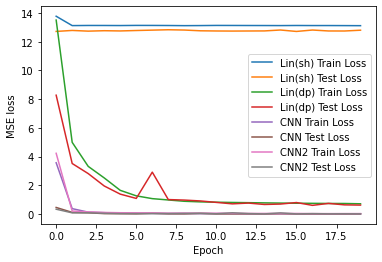

In [145]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_cnn2_data_label
)

In [52]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float().to(device)
mer8motif_model_cnn(dna_oh)

tensor([[14.0533]], device='cuda:0', grad_fn=<AddmmBackward>)

In [53]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:20.026 actual:20.000 (-0.026)
CCCCCCCC: pred:17.047 actual:17.000 (-0.047)
GGGGGGGG: pred:14.053 actual:14.000 (-0.053)
TTTTTTTT: pred:11.110 actual:11.000 (-0.110)

AACCAACA: pred:18.959 actual:18.875 (-0.084)
CCGGCGCG: pred:5.570 actual:5.500 (-0.070)
GGGTAAGG: pred:15.130 actual:15.125 (-0.005)
TTTCGTTT: pred:12.204 actual:12.125 (-0.079)
TGTAATAC: pred:15.614 actual:15.500 (-0.114)

TATAAAAA: pred:27.743 actual:27.750 (0.007)
CCTATCCC: pred:25.868 actual:25.875 (0.007)
GTATGGGG: pred:24.071 actual:24.000 (-0.071)
TTTATTTT: pred:22.410 actual:22.125 (-0.285)

AAGCGAAA: pred:8.154 actual:8.125 (-0.029)
CGCGCCCC: pred:6.142 actual:6.250 (0.108)
GGGCGGGG: pred:4.272 actual:4.375 (0.103)
TTGCGTTT: pred:2.648 actual:2.500 (-0.148)

ATATGCGA: pred:15.828 actual:15.875 (0.047)
TGCGTATT: pred:13.569 actual:13.625 (0.056)



In [59]:
def parity_pred(models, seqs, oracle,task,alt=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
            elif ds.name == 'kmer':
                s = torch.tensor(count_kmers_in_seq(dna,kmers(ds.k))).to(device)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")
        
                
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            u.alt_parity_plot(model_name, df, pearson,task)
        u.parity_plot(model_name, df, pearson)

    return dfs

Running LinearShallow_8mer


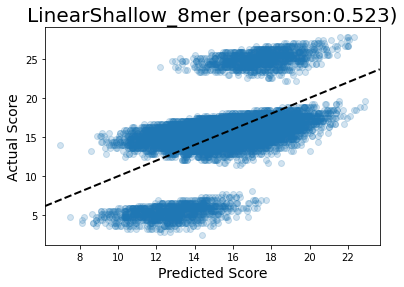

Running LinearDeep_8mer


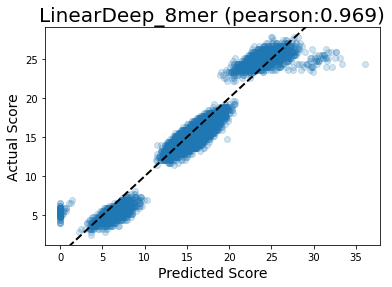

Running Kmer1_8mer


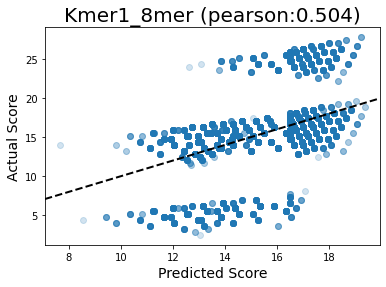

Running Kmer3_8mer


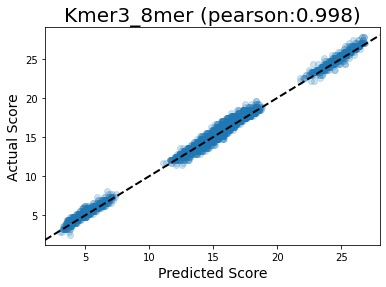

In [61]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s,DatasetSpec('ohe')),
    ("LinearDeep_8mer",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
    ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
    #("CNN_8mer",mer8motif_model_cnn),
    
    #("CNN2_8mer",mer8motif_model_cnn2),
]


seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

In [60]:
models = [
    ("CNNOPT",owcnn.best_model),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

NameError: name 'owcnn' is not defined